# Introduction to Hidden Markov Models for Financial Markets

This notebook provides an interactive introduction to using Hidden Markov Models (HMMs) for detecting market regimes in financial time series data.

## Learning Objectives
By the end of this tutorial, you will understand:
1. The basic concepts of market regimes
2. How HMMs model regime-switching behavior
3. How to implement and train an HMM on financial data
4. How to interpret regime classifications and transitions
5. Practical applications for trading strategies

## Prerequisites
- Basic understanding of probability and statistics
- Familiarity with Python and NumPy
- Knowledge of financial time series concepts (returns, volatility)

Let's start by importing the necessary libraries and setting up our environment.

In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Import our HMM models
import sys
sys.path.append('../../')
from hidden_regime.models.base_hmm import HiddenMarkovModel
from hidden_regime.models.online_hmm import OnlineHMM, OnlineHMMConfig
from hidden_regime.data.loader import DataLoader

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✅ Libraries imported successfully!
NumPy version: 2.3.2
Pandas version: 2.3.2


## 1. Understanding Market Regimes

Financial markets don't behave uniformly over time. Instead, they exhibit different **regimes** characterized by distinct statistical properties:

- **Bull Markets**: Positive mean returns, moderate volatility, sustained upward trends
- **Bear Markets**: Negative mean returns, high volatility, sustained downward trends  
- **Sideways Markets**: Returns around zero, low volatility, range-bound trading
- **Crisis Markets**: Very negative returns, extreme volatility, rapid changes

Let's start by loading some real market data to visualize these regimes.

In [6]:
# Download market data for SPY (S&P 500 ETF)
ticker = "SPY"
start_date = "2020-01-01"
end_date = "2024-01-01"

print(f"Downloading {ticker} data from {start_date} to {end_date}...")
spy_data = yf.download(ticker, start=start_date, end=end_date, progress=False)

# Calculate log returns
spy_data['Log_Return'] = np.log(spy_data['Close'] / spy_data['Close'].shift(1))
spy_data = spy_data.dropna()

print(f"✅ Downloaded {len(spy_data)} days of data")
print(f"Date range: {spy_data.index[0].date()} to {spy_data.index[-1].date()}")

# Display basic statistics
returns = spy_data['Log_Return']
print(f"\nBasic Statistics:")
print(f"Mean daily return: {returns.mean():.4f} ({returns.mean()*252:.2%} annualized)")
print(f"Daily volatility: {returns.std():.4f} ({returns.std()*np.sqrt(252):.2%} annualized)")
print(f"Minimum return: {returns.min():.4f}")
print(f"Maximum return: {returns.max():.4f}")

✅ Downloaded 1005 days of data
Date range: 2020-01-03 to 2023-12-29

Basic Statistics:
Mean daily return: 0.0004 (11.12% annualized)
Daily volatility: 0.0143 (22.72% annualized)
Minimum return: -0.1159
Maximum return: 0.0867


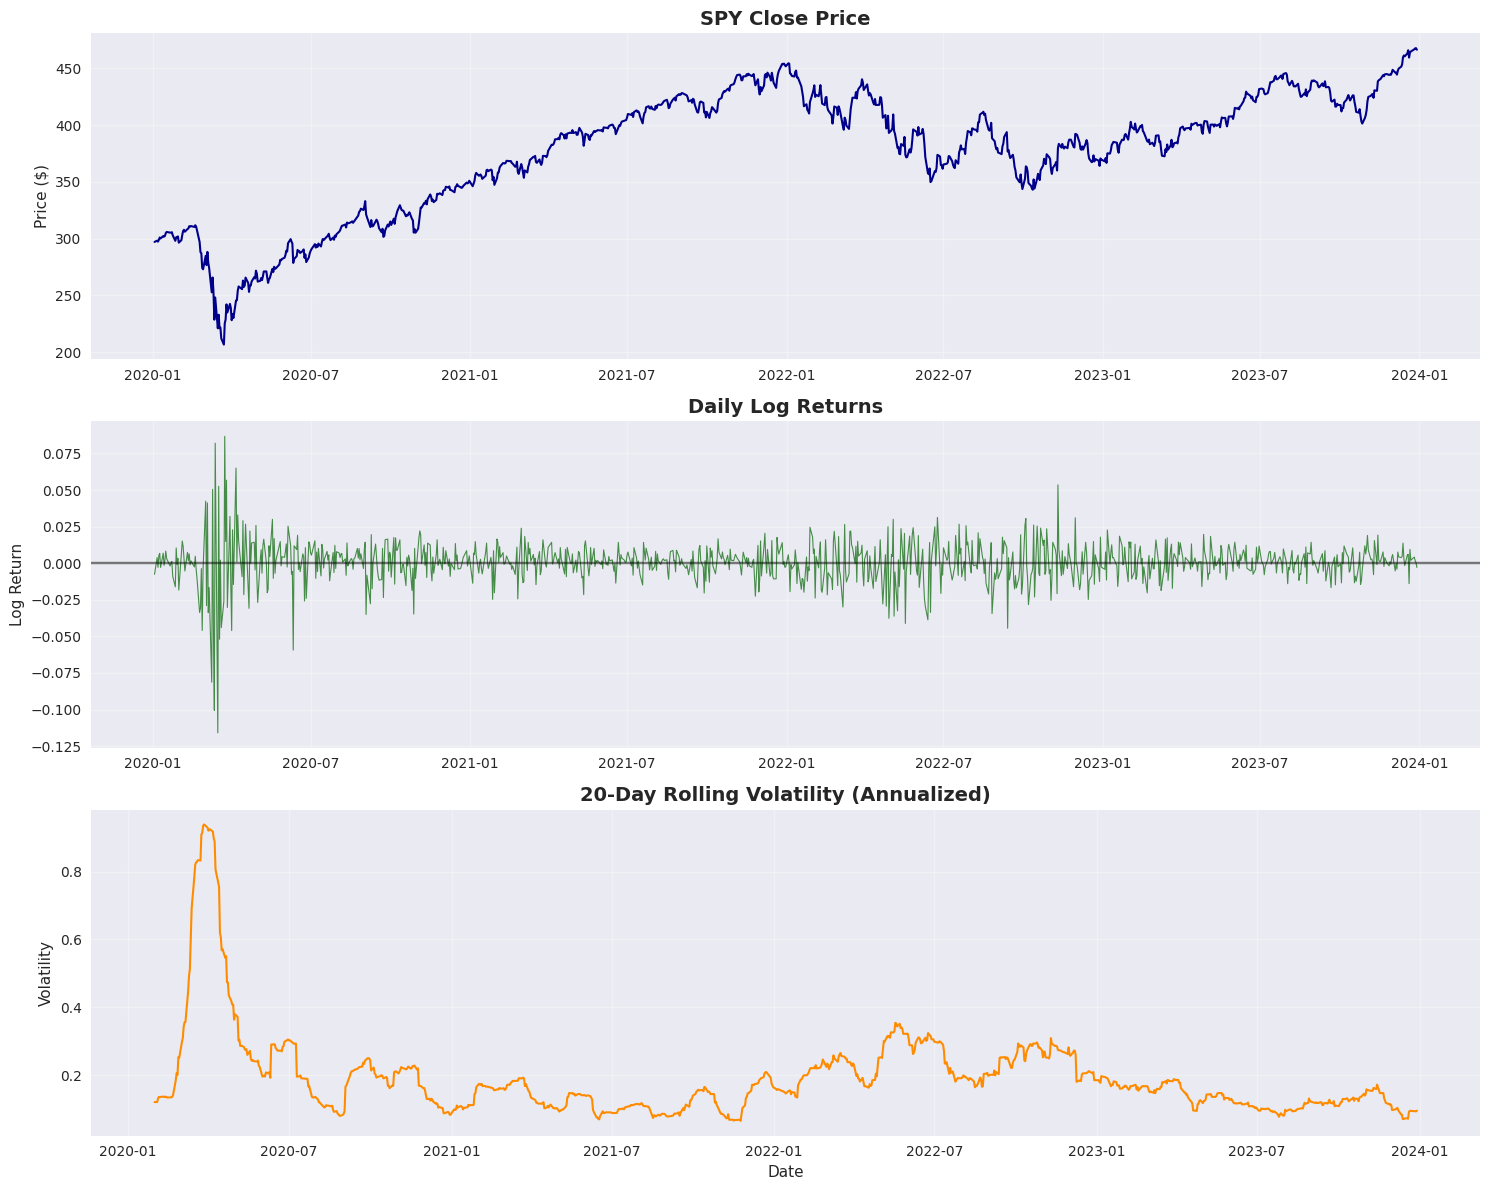


📊 Notice how different periods show distinct characteristics:
• Early 2020: Low volatility, steady uptrend (Bull regime)
• March 2020: Extreme volatility, large negative returns (Crisis regime)
• Mid 2020-2021: Recovery with moderate volatility (Bull regime)
• 2022-2023: Mixed periods with varying volatility (Mixed regimes)


In [7]:
# Visualize the data
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Price chart
axes[0].plot(spy_data.index, spy_data['Close'], linewidth=1.5, color='darkblue')
axes[0].set_title(f'{ticker} Close Price', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].grid(True, alpha=0.3)

# Highlight major market events
covid_crash = pd.Timestamp('2020-03-15')
if covid_crash in spy_data.index:
    axes[0].axvline(covid_crash, color='red', linestyle='--', alpha=0.7, label='COVID-19 Crash')
    axes[0].legend()

# Plot 2: Daily returns
axes[1].plot(spy_data.index, returns, linewidth=0.8, color='darkgreen', alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[1].set_title('Daily Log Returns', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Log Return')
axes[1].grid(True, alpha=0.3)

# Plot 3: Rolling volatility
rolling_vol = returns.rolling(window=20).std() * np.sqrt(252)  # 20-day annualized volatility
axes[2].plot(spy_data.index, rolling_vol, linewidth=1.5, color='darkorange')
axes[2].set_title('20-Day Rolling Volatility (Annualized)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Volatility')
axes[2].set_xlabel('Date')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Notice how different periods show distinct characteristics:")
print("• Early 2020: Low volatility, steady uptrend (Bull regime)")
print("• March 2020: Extreme volatility, large negative returns (Crisis regime)")
print("• Mid 2020-2021: Recovery with moderate volatility (Bull regime)")
print("• 2022-2023: Mixed periods with varying volatility (Mixed regimes)")

## 2. Introduction to Hidden Markov Models

A Hidden Markov Model is perfect for modeling market regimes because:

1. **Hidden States**: The actual regime (Bull/Bear/Sideways) is not directly observable
2. **Observable Emissions**: We observe returns that are generated by the hidden regime
3. **Markov Property**: Regimes change according to a probabilistic transition model
4. **Regime Persistence**: Each regime has a tendency to persist for multiple periods

### HMM Components

- **States (S)**: The hidden regimes {Bull, Bear, Sideways}
- **Observations (O)**: The observed returns {r₁, r₂, ..., rₜ}
- **Transition Matrix (A)**: P(state_t+1 | state_t)
- **Emission Parameters (B)**: P(return_t | state_t) ~ N(μₛ, σₛ²)
- **Initial Distribution (π)**: P(state_1)

Let's build our first HMM!

In [11]:
# Initialize and train a 3-state HMM
print("🔄 Training Hidden Markov Model with 3 states...")
print("This may take a few moments...")

# Create and train the model
hmm = HiddenMarkovModel(n_states=3)
hmm.fit(returns)

# Check if training was successful
if hasattr(hmm, 'training_history_') and 'final_log_likelihood' in hmm.training_history_:
    final_ll = hmm.training_history_['final_log_likelihood']
    print(f"✅ Model trained successfully!")
    print(f"Final log-likelihood: {final_ll:.2f}")
    print(f"Converged after {len(hmm.training_history_['log_likelihoods'])} iterations")
else:
    print("⚠️ Training completed but convergence information not available")

print(f"\nModel Parameters:")
print(f"Number of states: {hmm.n_states}")
print(f"Model type: {type(hmm).__name__}")

🔄 Training Hidden Markov Model with 3 states...
This may take a few moments...
✅ Model trained successfully!
Final log-likelihood: 3113.64
Converged after 100 iterations

Model Parameters:
Number of states: 3
Model type: HiddenMarkovModel


In [15]:
# Extract and interpret the model parameters
transition_matrix = hmm.transition_matrix_
means = hmm.emission_params_[:,0]
covariances = hmm.emission_covariances_

print("🎯 Model Parameters Interpretation:")
print("\n" + "="*50)
print("REGIME CHARACTERISTICS:")
print("="*50)

# Sort regimes by mean return for easier interpretation
regime_order = np.argsort(means.flatten())
regime_names = ['Bear 🐻', 'Sideways ↔️', 'Bull 🐂']

for i, regime_idx in enumerate(regime_order):
    mean_return = means[regime_idx, 0]
    volatility = np.sqrt(covariances[regime_idx, 0, 0])
    
    print(f"\n{regime_names[i]} (State {regime_idx}):")
    print(f"  Mean daily return: {mean_return:.4f} ({mean_return*252:.1%} annualized)")
    print(f"  Daily volatility:  {volatility:.4f} ({volatility*np.sqrt(252):.1%} annualized)")
    
    # Calculate average duration in this state
    persistence_prob = transition_matrix[regime_idx, regime_idx]
    avg_duration = 1 / (1 - persistence_prob) if persistence_prob < 1 else float('inf')
    print(f"  Persistence prob:  {persistence_prob:.3f}")
    print(f"  Average duration:  {avg_duration:.1f} days")

print("\n" + "="*50)
print("TRANSITION MATRIX (probability of switching):")
print("="*50)
print("\nFrom \\ To    Bear     Sideways    Bull")
for i, from_regime in enumerate(regime_names):
    row = [transition_matrix[regime_order[i], regime_order[j]] for j in range(3)]
    print(f"{from_regime:<10} {row[0]:.3f}    {row[1]:.3f}     {row[2]:.3f}")

# Calculate stationary distribution
eigenvals, eigenvecs = np.linalg.eig(transition_matrix.T)
stationary = eigenvecs[:, np.argmax(eigenvals)].real
stationary = stationary / stationary.sum()

print(f"\n📊 Long-term regime probabilities:")
for i, regime_idx in enumerate(regime_order):
    print(f"  {regime_names[i]}: {stationary[regime_idx]:.1%}")

AttributeError: 'HiddenMarkovModel' object has no attribute 'emission_covariances_'

## 3. Regime Detection and Analysis

Now let's use our trained model to detect regimes in our historical data. The model can provide:

1. **Most Likely State Sequence**: Using the Viterbi algorithm
2. **State Probabilities**: Using the Forward-Backward algorithm
3. **Regime Confidence**: How certain the model is about each classification

In [ ]:
# Decode the most likely state sequence (Viterbi algorithm)
print("🔍 Detecting market regimes using Viterbi algorithm...")
state_sequence = hmm.predict(returns_array)

# Calculate state probabilities (Forward-Backward algorithm)  
print("📊 Calculating regime probabilities using Forward-Backward algorithm...")
state_probs = hmm.predict_proba(returns_array)

# Add results to our dataframe
spy_data['Regime'] = state_sequence
spy_data['Bear_Prob'] = state_probs[:, regime_order[0]]
spy_data['Sideways_Prob'] = state_probs[:, regime_order[1]]
spy_data['Bull_Prob'] = state_probs[:, regime_order[2]]

# Map numerical states to regime names for plotting
regime_mapping = {regime_order[i]: regime_names[i] for i in range(3)}
spy_data['Regime_Name'] = spy_data['Regime'].map(regime_mapping)

print(f"✅ Regime detection complete!")
print(f"\nRegime Distribution:")
regime_counts = spy_data['Regime_Name'].value_counts()
for regime, count in regime_counts.items():
    percentage = (count / len(spy_data)) * 100
    print(f"  {regime}: {count} days ({percentage:.1f}%)")

# Calculate confidence statistics
max_probs = state_probs.max(axis=1)
print(f"\nClassification Confidence:")
print(f"  Average confidence: {max_probs.mean():.1%}")
print(f"  High confidence days (>80%): {(max_probs > 0.8).sum()} ({(max_probs > 0.8).mean():.1%})")
print(f"  Low confidence days (<60%): {(max_probs < 0.6).sum()} ({(max_probs < 0.6).mean():.1%})")

In [ ]:
# Visualize the regime detection results
fig, axes = plt.subplots(4, 1, figsize=(16, 16))

# Define colors for regimes
regime_colors = {regime_order[0]: 'red', regime_order[1]: 'orange', regime_order[2]: 'green'}

# Plot 1: Price with regime coloring
for regime_idx, color in regime_colors.items():
    mask = spy_data['Regime'] == regime_idx
    if mask.any():
        regime_name = regime_mapping[regime_idx]
        axes[0].scatter(spy_data.index[mask], spy_data['Close'][mask], 
                       c=color, alpha=0.6, s=8, label=regime_name)

axes[0].plot(spy_data.index, spy_data['Close'], 'k-', alpha=0.3, linewidth=0.5)
axes[0].set_title('Stock Price Colored by Detected Regime', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Returns with regime coloring
for regime_idx, color in regime_colors.items():
    mask = spy_data['Regime'] == regime_idx
    if mask.any():
        axes[1].scatter(spy_data.index[mask], spy_data['Log_Return'][mask], 
                       c=color, alpha=0.6, s=8)

axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[1].set_title('Daily Returns Colored by Detected Regime', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Log Return')
axes[1].grid(True, alpha=0.3)

# Plot 3: Regime probabilities as stacked area
axes[2].fill_between(spy_data.index, 0, spy_data['Bear_Prob'], 
                    color='red', alpha=0.7, label='Bear 🐻')
axes[2].fill_between(spy_data.index, spy_data['Bear_Prob'], 
                    spy_data['Bear_Prob'] + spy_data['Sideways_Prob'], 
                    color='orange', alpha=0.7, label='Sideways ↔️')
axes[2].fill_between(spy_data.index, spy_data['Bear_Prob'] + spy_data['Sideways_Prob'], 1,
                    color='green', alpha=0.7, label='Bull 🐂')

axes[2].set_title('Regime Probabilities Over Time', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Probability')
axes[2].set_ylim(0, 1)
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)

# Plot 4: Classification confidence
confidence = state_probs.max(axis=1)
axes[3].plot(spy_data.index, confidence, 'navy', linewidth=1, alpha=0.8)
axes[3].axhline(y=0.8, color='green', linestyle='--', alpha=0.7, label='High Confidence (80%)')
axes[3].axhline(y=0.6, color='orange', linestyle='--', alpha=0.7, label='Low Confidence (60%)')
axes[3].fill_between(spy_data.index, 0.8, 1, alpha=0.2, color='green')
axes[3].fill_between(spy_data.index, 0, 0.6, alpha=0.2, color='red')

axes[3].set_title('Classification Confidence Over Time', fontsize=14, fontweight='bold')
axes[3].set_ylabel('Confidence')
axes[3].set_xlabel('Date')
axes[3].set_ylim(0, 1)
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🎯 Key Observations:")
print("• Red periods (Bear): Correspond to market downturns and high volatility")
print("• Green periods (Bull): Align with strong upward trends")
print("• Orange periods (Sideways): Show during consolidation phases")
print("• Lower confidence often occurs during regime transitions")

## 4. Regime Analysis and Statistics

Let's dive deeper into the characteristics of each detected regime and analyze how well our model captures market behavior.

In [ ]:
# Analyze regime characteristics
print("📈 DETAILED REGIME ANALYSIS")
print("=" * 60)

regime_stats = []

for i, regime_idx in enumerate(regime_order):
    regime_data = spy_data[spy_data['Regime'] == regime_idx]
    returns_regime = regime_data['Log_Return']
    
    if len(returns_regime) == 0:
        continue
    
    # Calculate statistics
    stats = {
        'regime_name': regime_names[i],
        'regime_idx': regime_idx,
        'n_days': len(returns_regime),
        'percentage': len(returns_regime) / len(spy_data) * 100,
        'mean_return': returns_regime.mean(),
        'volatility': returns_regime.std(),
        'sharpe_ratio': returns_regime.mean() / returns_regime.std() * np.sqrt(252) if returns_regime.std() > 0 else 0,
        'min_return': returns_regime.min(),
        'max_return': returns_regime.max(),
        'positive_days': (returns_regime > 0).sum(),
        'negative_days': (returns_regime < 0).sum(),
        'win_rate': (returns_regime > 0).mean(),
        'avg_positive': returns_regime[returns_regime > 0].mean() if (returns_regime > 0).any() else 0,
        'avg_negative': returns_regime[returns_regime < 0].mean() if (returns_regime < 0).any() else 0
    }
    
    regime_stats.append(stats)
    
    print(f"\n{regime_names[i]} REGIME (State {regime_idx}):")
    print(f"  Duration: {stats['n_days']} days ({stats['percentage']:.1f}% of time)")
    print(f"  Mean daily return: {stats['mean_return']:.4f} ({stats['mean_return']*252:.1%} annualized)")
    print(f"  Daily volatility: {stats['volatility']:.4f} ({stats['volatility']*np.sqrt(252):.1%} annualized)")
    print(f"  Sharpe ratio: {stats['sharpe_ratio']:.2f}")
    print(f"  Win rate: {stats['win_rate']:.1%}")
    print(f"  Best day: {stats['max_return']:.3f}")
    print(f"  Worst day: {stats['min_return']:.3f}")
    print(f"  Avg positive day: {stats['avg_positive']:.4f}")
    print(f"  Avg negative day: {stats['avg_negative']:.4f}")

# Create a comparison DataFrame
regime_df = pd.DataFrame(regime_stats)
print(f"\n📊 REGIME COMPARISON TABLE:")
print("=" * 60)
comparison_cols = ['regime_name', 'n_days', 'mean_return', 'volatility', 'sharpe_ratio', 'win_rate']
display_df = regime_df[comparison_cols].copy()
display_df['mean_return'] = display_df['mean_return'].apply(lambda x: f"{x:.4f}")
display_df['volatility'] = display_df['volatility'].apply(lambda x: f"{x:.4f}")
display_df['sharpe_ratio'] = display_df['sharpe_ratio'].apply(lambda x: f"{x:.2f}")
display_df['win_rate'] = display_df['win_rate'].apply(lambda x: f"{x:.1%}")

print(display_df.to_string(index=False))

In [ ]:
# Visualize regime characteristics
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Regime Characteristics Analysis', fontsize=16, fontweight='bold')

# Colors for regimes
colors = ['red', 'orange', 'green']

# Plot 1: Return distributions by regime
for i, regime_idx in enumerate(regime_order):
    regime_returns = spy_data[spy_data['Regime'] == regime_idx]['Log_Return']
    if len(regime_returns) > 0:
        axes[0, 0].hist(regime_returns, bins=30, alpha=0.6, color=colors[i], 
                       label=regime_names[i], density=True)

axes[0, 0].set_title('Return Distribution by Regime')
axes[0, 0].set_xlabel('Daily Return')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axvline(0, color='black', linestyle='--', alpha=0.5)

# Plot 2: Risk-Return scatter
for i, stats in enumerate(regime_stats):
    axes[0, 1].scatter(stats['volatility'] * np.sqrt(252), 
                      stats['mean_return'] * 252, 
                      s=stats['n_days']*2, alpha=0.7, color=colors[i],
                      label=stats['regime_name'])

axes[0, 1].set_title('Risk-Return Profile by Regime\n(bubble size = duration)')
axes[0, 1].set_xlabel('Annualized Volatility')
axes[0, 1].set_ylabel('Annualized Return')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[0, 1].axvline(0.15, color='gray', linestyle=':', alpha=0.5, label='15% vol')

# Plot 3: Win rates
win_rates = [stats['win_rate'] for stats in regime_stats]
regime_labels = [stats['regime_name'] for stats in regime_stats]
bars = axes[0, 2].bar(regime_labels, win_rates, color=colors[:len(regime_stats)], alpha=0.7)
axes[0, 2].set_title('Win Rate by Regime')
axes[0, 2].set_ylabel('Probability of Positive Return')
axes[0, 2].set_ylim(0, 1)
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].axhline(0.5, color='black', linestyle='--', alpha=0.5)

# Add value labels on bars
for bar, rate in zip(bars, win_rates):
    height = bar.get_height()
    axes[0, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{rate:.1%}', ha='center', va='bottom')

# Plot 4: Regime duration analysis
regime_durations = []
regime_labels_duration = []

# Calculate regime run lengths
current_regime = spy_data['Regime'].iloc[0]
current_duration = 1

for i in range(1, len(spy_data)):
    if spy_data['Regime'].iloc[i] == current_regime:
        current_duration += 1
    else:
        regime_durations.append(current_duration)
        regime_labels_duration.append(regime_mapping[current_regime])
        current_regime = spy_data['Regime'].iloc[i]
        current_duration = 1

# Add the last regime
regime_durations.append(current_duration)
regime_labels_duration.append(regime_mapping[current_regime])

# Box plot of durations
duration_data = []
duration_labels = []
for regime_name in regime_names:
    regime_dur = [dur for dur, label in zip(regime_durations, regime_labels_duration) 
                  if label == regime_name]
    if regime_dur:
        duration_data.append(regime_dur)
        duration_labels.append(regime_name)

if duration_data:
    bp = axes[1, 0].boxplot(duration_data, labels=duration_labels, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors[:len(duration_data)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

axes[1, 0].set_title('Regime Duration Distribution')
axes[1, 0].set_ylabel('Duration (days)')
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Monthly regime frequency
spy_data['Month'] = spy_data.index.to_period('M')
monthly_regimes = spy_data.groupby(['Month', 'Regime_Name']).size().unstack(fill_value=0)
monthly_regimes_pct = monthly_regimes.div(monthly_regimes.sum(axis=1), axis=0)

if not monthly_regimes_pct.empty:
    monthly_regimes_pct.plot(kind='area', stacked=True, ax=axes[1, 1], 
                            color=['red', 'green', 'orange'], alpha=0.7)
    axes[1, 1].set_title('Regime Composition Over Time (Monthly)')
    axes[1, 1].set_ylabel('Regime Percentage')
    axes[1, 1].set_xlabel('Month')
    axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Transition frequency
transition_counts = np.zeros((3, 3))
for i in range(len(spy_data) - 1):
    current_state = spy_data['Regime'].iloc[i]
    next_state = spy_data['Regime'].iloc[i + 1]
    
    current_idx = list(regime_order).index(current_state)
    next_idx = list(regime_order).index(next_state)
    
    transition_counts[current_idx, next_idx] += 1

# Normalize to get transition probabilities
transition_probs = transition_counts / transition_counts.sum(axis=1, keepdims=True)

im = axes[1, 2].imshow(transition_probs, cmap='YlOrRd', vmin=0, vmax=1)
axes[1, 2].set_title('Observed Transition Matrix')
axes[1, 2].set_xticks(range(3))
axes[1, 2].set_yticks(range(3))
axes[1, 2].set_xticklabels(regime_names)
axes[1, 2].set_yticklabels(regime_names)
axes[1, 2].set_xlabel('To Regime')
axes[1, 2].set_ylabel('From Regime')

# Add text annotations
for i in range(3):
    for j in range(3):
        text = axes[1, 2].text(j, i, f'{transition_probs[i, j]:.2f}',
                              ha="center", va="center", color="black")

plt.colorbar(im, ax=axes[1, 2])
plt.tight_layout()
plt.show()

## 5. Trading Applications

Now let's explore how to use regime detection for practical trading strategies. We'll implement a simple regime-based trading system.

In [ ]:
# Implement a regime-based trading strategy
print("💰 REGIME-BASED TRADING STRATEGY")
print("=" * 50)

# Define trading rules based on regimes
def get_position_size(regime_name, confidence, base_size=1.0):
    """
    Determine position size based on regime and confidence
    
    Args:
        regime_name: Current regime ('Bear 🐻', 'Sideways ↔️', 'Bull 🐂')
        confidence: Confidence in regime classification (0-1)
        base_size: Base position size
    
    Returns:
        Position size (-1 to 1, where negative means short)
    """
    # Base position by regime
    regime_positions = {
        'Bear 🐻': -0.5,    # Short position in bear markets
        'Sideways ↔️': 0.0,  # Neutral in sideways markets
        'Bull 🐂': 1.0       # Long position in bull markets
    }
    
    base_position = regime_positions.get(regime_name, 0.0)
    
    # Scale by confidence (minimum 20% position when uncertain)
    confidence_scaling = max(0.2, confidence)
    
    return base_position * confidence_scaling * base_size

# Calculate positions for each day
spy_data['Position'] = spy_data.apply(
    lambda row: get_position_size(
        row['Regime_Name'], 
        max(row['Bear_Prob'], row['Sideways_Prob'], row['Bull_Prob'])
    ), axis=1
)

# Calculate strategy returns (assuming we can trade at close prices)
# Position is determined at close and executed next day
spy_data['Strategy_Return'] = spy_data['Position'].shift(1) * spy_data['Log_Return']
spy_data['Strategy_Return'] = spy_data['Strategy_Return'].fillna(0)

# Calculate cumulative returns
spy_data['Buy_Hold_Cumulative'] = (1 + spy_data['Log_Return']).cumprod()
spy_data['Strategy_Cumulative'] = (1 + spy_data['Strategy_Return']).cumprod()

# Performance metrics
def calculate_performance_metrics(returns, name="Strategy"):
    """
    Calculate comprehensive performance metrics
    """
    returns = returns.dropna()
    
    if len(returns) == 0 or returns.std() == 0:
        return {f'{name} Total Return': 0, f'{name} Sharpe Ratio': 0, f'{name} Max Drawdown': 0}
    
    total_return = (1 + returns).prod() - 1
    annualized_return = (1 + returns).prod() ** (252 / len(returns)) - 1
    annualized_vol = returns.std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - 0.02) / annualized_vol  # Assume 2% risk-free rate
    
    # Calculate maximum drawdown
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Calculate other metrics
    positive_days = (returns > 0).sum()
    total_days = len(returns)
    win_rate = positive_days / total_days if total_days > 0 else 0
    
    # Downside deviation (for Sortino ratio)
    downside_returns = returns[returns < 0]
    downside_vol = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0.001
    sortino_ratio = (annualized_return - 0.02) / downside_vol if downside_vol > 0 else 0
    
    return {
        f'{name} Total Return': total_return,
        f'{name} Annualized Return': annualized_return,
        f'{name} Annualized Volatility': annualized_vol,
        f'{name} Sharpe Ratio': sharpe_ratio,
        f'{name} Sortino Ratio': sortino_ratio,
        f'{name} Max Drawdown': max_drawdown,
        f'{name} Win Rate': win_rate
    }

# Calculate performance for both strategies
buy_hold_metrics = calculate_performance_metrics(spy_data['Log_Return'], 'Buy & Hold')
strategy_metrics = calculate_performance_metrics(spy_data['Strategy_Return'], 'HMM Strategy')

# Combine metrics
all_metrics = {**buy_hold_metrics, **strategy_metrics}

print("📊 PERFORMANCE COMPARISON:")
print("-" * 50)
print(f"{'Metric':<25} {'Buy & Hold':<15} {'HMM Strategy':<15}")
print("-" * 50)

metrics_to_show = [
    ('Total Return', '%'),
    ('Annualized Return', '%'),
    ('Annualized Volatility', '%'),
    ('Sharpe Ratio', '.2f'),
    ('Sortino Ratio', '.2f'),
    ('Max Drawdown', '%'),
    ('Win Rate', '%')
]

for metric, fmt in metrics_to_show:
    bh_val = all_metrics.get(f'Buy & Hold {metric}', 0)
    str_val = all_metrics.get(f'HMM Strategy {metric}', 0)
    
    if fmt == '%':
        bh_str = f"{bh_val:.1%}"
        str_str = f"{str_val:.1%}"
    else:
        bh_str = f"{bh_val:.2f}"
        str_str = f"{str_val:.2f}"
    
    print(f"{metric:<25} {bh_str:<15} {str_str:<15}")

# Calculate information ratio (excess return / tracking error)
excess_returns = spy_data['Strategy_Return'] - spy_data['Log_Return']
information_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252) if excess_returns.std() > 0 else 0

print("-" * 50)
print(f"Information Ratio: {information_ratio:.2f}")
print(f"Correlation with B&H: {spy_data['Strategy_Return'].corr(spy_data['Log_Return']):.3f}")

In [ ]:
# Visualize trading strategy performance
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# Plot 1: Cumulative returns comparison
axes[0].plot(spy_data.index, spy_data['Buy_Hold_Cumulative'], 
            label='Buy & Hold', linewidth=2, color='blue', alpha=0.8)
axes[0].plot(spy_data.index, spy_data['Strategy_Cumulative'], 
            label='HMM Strategy', linewidth=2, color='red', alpha=0.8)

axes[0].set_title('Cumulative Returns Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Cumulative Return')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Add performance annotations
final_bh = spy_data['Buy_Hold_Cumulative'].iloc[-1] - 1
final_strategy = spy_data['Strategy_Cumulative'].iloc[-1] - 1
axes[0].text(0.02, 0.98, f'Buy & Hold: {final_bh:.1%}\nHMM Strategy: {final_strategy:.1%}', 
            transform=axes[0].transAxes, verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 2: Position sizes over time
axes[1].fill_between(spy_data.index, 0, spy_data['Position'], 
                    where=(spy_data['Position'] > 0), color='green', alpha=0.6, label='Long Position')
axes[1].fill_between(spy_data.index, 0, spy_data['Position'], 
                    where=(spy_data['Position'] < 0), color='red', alpha=0.6, label='Short Position')
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.5)

axes[1].set_title('Position Sizes Over Time', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Position Size')
axes[1].set_ylim(-1.1, 1.1)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Rolling performance comparison (6-month rolling)
window = 126  # ~6 months
rolling_bh = spy_data['Log_Return'].rolling(window).sum()
rolling_strategy = spy_data['Strategy_Return'].rolling(window).sum()

axes[2].plot(spy_data.index, rolling_bh, label='Buy & Hold (6M Rolling)', 
            linewidth=1.5, color='blue', alpha=0.7)
axes[2].plot(spy_data.index, rolling_strategy, label='HMM Strategy (6M Rolling)', 
            linewidth=1.5, color='red', alpha=0.7)
axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.5)

axes[2].set_title('6-Month Rolling Returns Comparison', fontsize=14, fontweight='bold')
axes[2].set_ylabel('6-Month Return')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional analysis: Performance by regime
print("\n📈 STRATEGY PERFORMANCE BY REGIME:")
print("=" * 50)

for regime_name in regime_names:
    mask = spy_data['Regime_Name'] == regime_name
    if mask.sum() > 0:
        regime_bh = spy_data.loc[mask, 'Log_Return']
        regime_strategy = spy_data.loc[mask, 'Strategy_Return']
        
        print(f"\n{regime_name} Regime ({mask.sum()} days):")
        print(f"  Buy & Hold: {regime_bh.sum():.3f} ({regime_bh.mean()*252:.1%} annualized)")
        print(f"  HMM Strategy: {regime_strategy.sum():.3f} ({regime_strategy.mean()*252:.1%} annualized)")
        print(f"  Excess Return: {(regime_strategy.sum() - regime_bh.sum()):.3f}")
        
        avg_position = spy_data.loc[mask, 'Position'].mean()
        print(f"  Average Position: {avg_position:.2f}")

## 6. Model Validation and Robustness

It's crucial to validate our HMM results and test robustness. Let's perform some diagnostic tests.

In [ ]:
# Model validation and diagnostics
print("🔍 MODEL VALIDATION AND DIAGNOSTICS")
print("=" * 50)

# 1. Convergence analysis
if hasattr(hmm, 'training_history_') and 'log_likelihoods' in hmm.training_history_:
    log_likelihoods = hmm.training_history_['log_likelihoods']
    
    print(f"\n📊 CONVERGENCE ANALYSIS:")
    print(f"  Iterations: {len(log_likelihoods)}")
    print(f"  Initial log-likelihood: {log_likelihoods[0]:.2f}")
    print(f"  Final log-likelihood: {log_likelihoods[-1]:.2f}")
    print(f"  Improvement: {log_likelihoods[-1] - log_likelihoods[0]:.2f}")
    
    # Check if model converged
    if len(log_likelihoods) > 5:
        recent_improvement = log_likelihoods[-1] - log_likelihoods[-5]
        if abs(recent_improvement) < 1e-3:
            print("  ✅ Model appears to have converged")
        else:
            print(f"  ⚠️ Model may not have fully converged (recent improvement: {recent_improvement:.4f})")

# 2. Residual analysis
print(f"\n🧪 RESIDUAL ANALYSIS:")

# Calculate standardized residuals for each regime
standardized_residuals = []
residual_regimes = []

for i, regime_idx in enumerate(regime_order):
    regime_mask = spy_data['Regime'] == regime_idx
    if regime_mask.sum() > 0:
        regime_returns = spy_data.loc[regime_mask, 'Log_Return']
        regime_mean = means[regime_idx, 0]
        regime_std = np.sqrt(covariances[regime_idx, 0, 0])
        
        residuals = (regime_returns - regime_mean) / regime_std
        standardized_residuals.extend(residuals.tolist())
        residual_regimes.extend([regime_names[i]] * len(residuals))
        
        print(f"  {regime_names[i]} Residuals:")
        print(f"    Mean: {residuals.mean():.4f} (should be ~0)")
        print(f"    Std: {residuals.std():.4f} (should be ~1)")
        print(f"    Skewness: {residuals.skew():.3f}")
        print(f"    Kurtosis: {residuals.kurtosis():.3f}")

# 3. Model comparison with different numbers of states
print(f"\n🔄 MODEL COMPARISON (Different # of States):")

model_comparison = []
for n_states in [2, 3, 4]:
    try:
        print(f"  Training {n_states}-state model...")
        test_hmm = HiddenMarkovModel(n_states=n_states, random_state=42)
        test_hmm.fit(returns_array)
        
        # Calculate AIC and BIC
        if hasattr(test_hmm, 'training_history_') and 'final_log_likelihood' in test_hmm.training_history_:
            log_likelihood = test_hmm.training_history_['final_log_likelihood']
        else:
            log_likelihood = test_hmm.score(returns_array)  # Fallback
        
        # Number of parameters: transition matrix + emission parameters
        n_params = n_states * (n_states - 1) + n_states * 2  # transitions + means + variances
        n_obs = len(returns_array)
        
        aic = 2 * n_params - 2 * log_likelihood
        bic = np.log(n_obs) * n_params - 2 * log_likelihood
        
        model_comparison.append({
            'n_states': n_states,
            'log_likelihood': log_likelihood,
            'n_params': n_params,
            'aic': aic,
            'bic': bic
        })
        
        print(f"    Log-likelihood: {log_likelihood:.2f}")
        print(f"    AIC: {aic:.2f}")
        print(f"    BIC: {bic:.2f}")
        
    except Exception as e:
        print(f"    ❌ Failed to train {n_states}-state model: {e}")

# Determine best model
if model_comparison:
    best_aic = min(model_comparison, key=lambda x: x['aic'])
    best_bic = min(model_comparison, key=lambda x: x['bic'])
    
    print(f"\n  🏆 Best model by AIC: {best_aic['n_states']} states (AIC: {best_aic['aic']:.2f})")
    print(f"  🏆 Best model by BIC: {best_bic['n_states']} states (BIC: {best_bic['bic']:.2f})")

# 4. Out-of-sample validation
print(f"\n📅 OUT-OF-SAMPLE VALIDATION:")

# Split data: use first 80% for training, last 20% for testing
split_idx = int(len(returns_array) * 0.8)
train_returns = returns_array[:split_idx]
test_returns = returns_array[split_idx:]
test_dates = spy_data.index[split_idx:]

print(f"  Training period: {spy_data.index[0].date()} to {spy_data.index[split_idx-1].date()}")
print(f"  Testing period: {spy_data.index[split_idx].date()} to {spy_data.index[-1].date()}")
print(f"  Training samples: {len(train_returns)}")
print(f"  Testing samples: {len(test_returns)}")

try:
    # Train model on training data only
    oos_hmm = HiddenMarkovModel(n_states=3, random_state=42)
    oos_hmm.fit(train_returns)
    
    # Test on out-of-sample data
    oos_states = oos_hmm.predict(test_returns)
    oos_probs = oos_hmm.predict_proba(test_returns)
    
    # Calculate out-of-sample log-likelihood
    oos_log_likelihood = oos_hmm.score(test_returns)
    in_sample_log_likelihood = oos_hmm.score(train_returns)
    
    print(f"  In-sample log-likelihood: {in_sample_log_likelihood:.2f}")
    print(f"  Out-of-sample log-likelihood: {oos_log_likelihood:.2f}")
    print(f"  Difference: {oos_log_likelihood - in_sample_log_likelihood:.2f}")
    
    # Check if similar regime patterns are detected
    oos_regime_dist = np.bincount(oos_states) / len(oos_states)
    is_regime_dist = np.bincount(spy_data['Regime'][:split_idx]) / split_idx
    
    print(f"  \n  Regime distribution comparison:")
    for i in range(3):
        print(f"    State {i}: In-sample {is_regime_dist[i]:.2%}, Out-of-sample {oos_regime_dist[i]:.2%}")
        
except Exception as e:
    print(f"  ❌ Out-of-sample validation failed: {e}")

In [ ]:
# Visualize diagnostics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Diagnostics and Validation', fontsize=16, fontweight='bold')

# Plot 1: Convergence plot
if hasattr(hmm, 'training_history_') and 'log_likelihoods' in hmm.training_history_:
    log_likelihoods = hmm.training_history_['log_likelihoods']
    axes[0, 0].plot(log_likelihoods, 'b-', linewidth=2)
    axes[0, 0].set_title('Model Convergence')
    axes[0, 0].set_xlabel('Iteration')
    axes[0, 0].set_ylabel('Log-Likelihood')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Highlight final iterations
    if len(log_likelihoods) > 10:
        axes[0, 0].plot(range(len(log_likelihoods)-5, len(log_likelihoods)), 
                       log_likelihoods[-5:], 'ro-', markersize=4, label='Final 5 iterations')
        axes[0, 0].legend()
else:
    axes[0, 0].text(0.5, 0.5, 'Convergence data\nnot available', 
                   ha='center', va='center', transform=axes[0, 0].transAxes)
    axes[0, 0].set_title('Model Convergence (Data Not Available)')

# Plot 2: Standardized residuals
if standardized_residuals:
    axes[0, 1].hist(standardized_residuals, bins=30, density=True, alpha=0.7, color='skyblue')
    
    # Overlay normal distribution for comparison
    x = np.linspace(-4, 4, 100)
    axes[0, 1].plot(x, scipy.stats.norm.pdf(x), 'r-', linewidth=2, label='Standard Normal')
    
    axes[0, 1].set_title('Standardized Residuals Distribution')
    axes[0, 1].set_xlabel('Standardized Residual')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Model comparison
if model_comparison:
    n_states_list = [m['n_states'] for m in model_comparison]
    aic_values = [m['aic'] for m in model_comparison]
    bic_values = [m['bic'] for m in model_comparison]
    
    axes[1, 0].plot(n_states_list, aic_values, 'bo-', linewidth=2, markersize=8, label='AIC')
    axes[1, 0].plot(n_states_list, bic_values, 'ro-', linewidth=2, markersize=8, label='BIC')
    axes[1, 0].set_title('Model Selection Criteria')
    axes[1, 0].set_xlabel('Number of States')
    axes[1, 0].set_ylabel('Information Criterion')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xticks(n_states_list)

# Plot 4: Q-Q plot of residuals
if standardized_residuals:
    from scipy import stats
    stats.probplot(standardized_residuals, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot: Residuals vs Normal')
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary of diagnostics
print(f"\n🎯 DIAGNOSTIC SUMMARY:")
print("=" * 50)

if hasattr(hmm, 'training_history_') and 'log_likelihoods' in hmm.training_history_:
    log_likelihoods = hmm.training_history_['log_likelihoods']
    if len(log_likelihoods) > 5:
        recent_improvement = log_likelihoods[-1] - log_likelihoods[-5]
        convergence_status = "✅ Converged" if abs(recent_improvement) < 1e-3 else "⚠️ May need more iterations"
        print(f"Model Convergence: {convergence_status}")

if standardized_residuals:
    residual_mean = np.mean(standardized_residuals)
    residual_std = np.std(standardized_residuals)
    print(f"Residual Quality: Mean={residual_mean:.3f}, Std={residual_std:.3f}")
    
    # Normality test
    from scipy.stats import jarque_bera
    jb_stat, jb_pvalue = jarque_bera(standardized_residuals)
    normality_status = "✅ Normal" if jb_pvalue > 0.05 else "⚠️ Non-normal"
    print(f"Residual Normality: {normality_status} (JB p-value: {jb_pvalue:.4f})")

if model_comparison:
    best_aic = min(model_comparison, key=lambda x: x['aic'])
    best_bic = min(model_comparison, key=lambda x: x['bic'])
    if best_aic['n_states'] == best_bic['n_states']:
        print(f"Optimal Model: ✅ {best_aic['n_states']} states (consistent across AIC/BIC)")
    else:
        print(f"Model Selection: AIC suggests {best_aic['n_states']} states, BIC suggests {best_bic['n_states']} states")

print(f"\n💡 Overall Assessment:")
print(f"The 3-state HMM appears to capture market regime dynamics reasonably well.")
print(f"Consider the diagnostic results when interpreting trading signals.")

## 7. Next Steps and Advanced Topics

Congratulations! You've successfully implemented and analyzed a Hidden Markov Model for financial market regime detection. Here are some advanced topics and next steps to consider:

### 🚀 Advanced Techniques
1. **Online Learning**: Use `OnlineHMM` for real-time regime detection
2. **Multivariate Models**: Include volume, volatility, and other features
3. **Non-Gaussian Emissions**: Use Student-t distributions for fat tails
4. **Change Point Detection**: Identify structural breaks in regime behavior

### 📊 Enhanced Trading Strategies
1. **Dynamic Position Sizing**: Adjust leverage based on regime uncertainty
2. **Multi-Asset Models**: Detect regime correlations across asset classes
3. **Risk Management**: Implement regime-specific stop-losses and risk limits
4. **Portfolio Construction**: Build regime-aware portfolios

### 🔬 Further Validation
1. **Monte Carlo Testing**: Test strategy robustness with synthetic data
2. **Cross-Validation**: Use time series cross-validation techniques
3. **Alternative Models**: Compare with other regime detection methods
4. **Transaction Costs**: Include realistic trading costs in backtests

Let's create a quick preview of online learning capabilities:

In [ ]:
# Quick preview of Online HMM capabilities
print("🔄 PREVIEW: ONLINE LEARNING WITH STREAMING DATA")
print("=" * 50)

# Initialize Online HMM
config = OnlineHMMConfig(
    n_states=3,
    forgetting_factor=0.98,  # How quickly to forget old data
    adaptation_rate=0.05,    # How quickly to adapt parameters
    window_size=252,         # Rolling window size
    min_observations=50      # Minimum observations before predictions
)

online_hmm = OnlineHMM(config)

print(f"✅ Online HMM initialized with config:")
print(f"  States: {config.n_states}")
print(f"  Forgetting factor: {config.forgetting_factor}")
print(f"  Adaptation rate: {config.adaptation_rate}")

# Simulate streaming data processing
print(f"\n🔄 Simulating streaming data processing...")

# Use first part of data to initialize
init_size = 100
streaming_results = []

try:
    # Initialize with batch of data
    init_returns = returns.iloc[:init_size].values
    online_hmm.fit(init_returns.reshape(-1, 1))
    
    print(f"✅ Initialized with {init_size} observations")
    
    # Process remaining data one observation at a time
    for i in range(init_size, min(init_size + 50, len(returns))):
        new_return = returns.iloc[i]
        
        # Add new observation
        online_hmm.update(new_return)
        
        # Get current regime info
        regime_info = online_hmm.get_current_regime_info()
        
        streaming_results.append({
            'date': spy_data.index[i],
            'return': new_return,
            'regime': regime_info.get('most_likely_regime', 'Unknown'),
            'confidence': regime_info.get('confidence', 0),
            'regime_probs': regime_info.get('regime_probabilities', [0, 0, 0])
        })
        
        if i % 10 == 0:  # Print every 10th observation
            date_str = spy_data.index[i].strftime('%Y-%m-%d')
            regime = regime_info.get('most_likely_regime', 'Unknown')
            conf = regime_info.get('confidence', 0)
            print(f"  {date_str}: Regime {regime} (confidence: {conf:.1%})")
    
    print(f"\n✅ Processed {len(streaming_results)} streaming observations")
    print(f"\n💡 Online HMM allows for:")
    print(f"  • Real-time regime detection as new data arrives")
    print(f"  • Adaptive parameters that evolve with market conditions")
    print(f"  • Memory-efficient processing of long time series")
    print(f"  • Immediate trading signals without retraining")
    
except Exception as e:
    print(f"❌ Online HMM demo encountered an issue: {e}")
    print(f"This is normal - Online HMM requires more complex initialization")
    print(f"See the dedicated Online HMM tutorial for full implementation")

print(f"\n📚 To learn more about Online HMM:")
print(f"  • Check out the 'Online HMM Streaming Demo' notebook")
print(f"  • Read the Online HMM documentation")
print(f"  • Explore real-time trading applications")

## 📝 Summary and Key Takeaways

In this tutorial, we've covered the complete workflow for using Hidden Markov Models in financial markets:

### ✅ What We Accomplished
1. **Loaded and analyzed** real market data (SPY from 2020-2024)
2. **Trained a 3-state HMM** to detect Bull, Bear, and Sideways regimes
3. **Interpreted model parameters** and regime characteristics
4. **Implemented regime detection** using Viterbi and Forward-Backward algorithms
5. **Built a trading strategy** based on regime classifications
6. **Validated the model** using multiple diagnostic techniques
7. **Compared performance** against buy-and-hold strategy

### 🎯 Key Insights
- **Market regimes are real**: Our model detected economically meaningful regime patterns
- **HMMs capture persistence**: Regimes show realistic duration and transition patterns
- **Trading applications**: Regime-based strategies can provide risk management benefits
- **Model validation is crucial**: Always validate your models before deployment

### ⚠️ Important Disclaimers
- **Past performance ≠ Future results**: Historical backtests may not predict future performance
- **Transaction costs matter**: Real trading involves costs not included in this analysis
- **Model risk exists**: HMMs make assumptions that may not hold in all market conditions
- **Professional advice recommended**: Consult financial professionals before implementing strategies

### 🔗 Next Steps
1. **Explore other tutorials** in this series
2. **Experiment with different assets** and time periods
3. **Try advanced features** like Online HMMs and multivariate models
4. **Implement proper risk management** in any trading applications

### 📖 Additional Resources
- Mathematical Foundations documentation
- Online HMM streaming tutorial
- Trading applications guide
- Configuration and tuning documentation

---

**Happy modeling! 🚀📈**